[View in Colaboratory](https://colab.research.google.com/github/billmlion/keras_ws/blob/master/14_keras_IMDB_MLP_LSTM.ipynb)

>[1.数据准备](#scrollTo=0cP5Qycmf1eC)

>[2.建立模型](#scrollTo=-OLzd647gKll)

>[3.训练模型](#scrollTo=aeHIF6RPgdB1)

>[4.评估准确率](#scrollTo=oJ3ev0lAg30n)



# 1.数据准备

In [1]:
import urllib.request
import os
import tarfile

url="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filepath="aclImdb_v1.tar.gz"

if not os.path.isfile(filepath):
    result=urllib.request.urlretrieve(url,filepath)
    print('downloaded:',result)
    
if not os.path.exists("aclImdb"):
    tfile = tarfile.open("aclImdb_v1.tar.gz", 'r:gz')
    result=tfile.extractall('')
    
    
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import numpy as np
np.random.seed(10)


import re
re_tag = re.compile(r'<[^>]+>')

def rm_tags(text):
    return re_tag.sub('', text)
  
  
  
import os
def read_files(filetype):
    path = "aclImdb/"
    file_list=[]

    positive_path=path + filetype+"/pos/"
    for f in os.listdir(positive_path):
        file_list+=[positive_path+f]
    
    negative_path=path + filetype+"/neg/"
    for f in os.listdir(negative_path):
        file_list+=[negative_path+f]
        
    print('read',filetype, 'files:',len(file_list))
       
    all_labels = ([1] * 12500 + [0] * 12500) 
    
    all_texts  = []
    
    for fi in file_list:
        with open(fi,encoding='utf8') as file_input:
            all_texts += [rm_tags(" ".join(file_input.readlines()))]
            
    return all_labels,all_texts

  
y_train,train_text=read_files("train")

y_test,test_text=read_files("test")

#先读取所有文章建立字典，限制字典的数量为nb_words=3800

token = Tokenizer(num_words=3800)
token.fit_on_texts(train_text)


x_train_seq = token.texts_to_sequences(train_text)
x_test_seq  = token.texts_to_sequences(test_text)

#截长补短，让所有影评所产生的数字序列长度一样
x_train = sequence.pad_sequences(x_train_seq, maxlen=380)
x_test  = sequence.pad_sequences(x_test_seq,  maxlen=380)

Using TensorFlow backend.


read train files: 25000
read test files: 25000


# 2.建立模型

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM


model = Sequential()

model.add(Embedding(output_dim=32,
                    input_dim=3800, 
                    input_length=380))
model.add(Dropout(0.2))

model.add(LSTM(32))

model.add(Dense(units=256,
                activation='relu' ))
model.add(Dropout(0.2))

model.add(Dense(units=1,
                activation='sigmoid' ))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 380, 32)           121600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 380, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 138,625
Trainable params: 138,625
Non-trainable params: 0
_________________________________________________________________


# 3.训练模型

In [3]:
model.compile(loss='binary_crossentropy', 
              #optimizer='rmsprop', 
              optimizer='adam', 
              metrics=['accuracy'])

train_history =model.fit(x_train, y_train,batch_size=100, 
                         epochs=10,verbose=2,
                         validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 70s - loss: 0.4776 - acc: 0.7607 - val_loss: 0.4100 - val_acc: 0.8326
Epoch 2/10
 - 69s - loss: 0.2627 - acc: 0.8946 - val_loss: 0.3216 - val_acc: 0.8614
Epoch 3/10
 - 68s - loss: 0.2294 - acc: 0.9112 - val_loss: 0.5306 - val_acc: 0.7826
Epoch 4/10
 - 69s - loss: 0.1967 - acc: 0.9250 - val_loss: 0.4625 - val_acc: 0.8186
Epoch 5/10
 - 69s - loss: 0.1878 - acc: 0.9289 - val_loss: 0.4769 - val_acc: 0.8090
Epoch 6/10
 - 69s - loss: 0.1802 - acc: 0.9321 - val_loss: 0.2733 - val_acc: 0.8966
Epoch 7/10
 - 68s - loss: 0.1585 - acc: 0.9397 - val_loss: 0.4606 - val_acc: 0.8338
Epoch 8/10
 - 69s - loss: 0.1348 - acc: 0.9514 - val_loss: 0.5195 - val_acc: 0.8300
Epoch 9/10
 - 69s - loss: 0.1244 - acc: 0.9558 - val_loss: 0.6542 - val_acc: 0.8036
Epoch 10/10
 - 69s - loss: 0.1120 - acc: 0.9598 - val_loss: 0.6959 - val_acc: 0.7814


In [4]:
%pylab inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    

Populating the interactive namespace from numpy and matplotlib


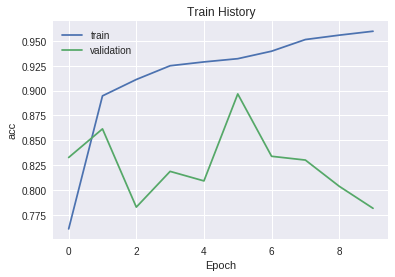

In [5]:
show_train_history(train_history,'acc','val_acc')

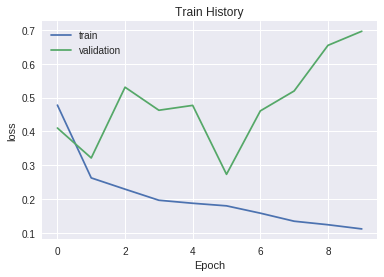

In [6]:
show_train_history(train_history,'loss','val_loss')

# 4.评估准确率

In [7]:
scores = model.evaluate(x_test, y_test, verbose=1)
scores[1]

25000/25000 [==============================] - 28s 1ms/step


0.84888